In [ ]:
pip install --upgrade fsspec

In [ ]:
!pip install datasets

In [ ]:
%%capture
! pip install git+https://github.com/PytorchLightning/pytorch-lightning-bolts.git@master --upgrade
! pip install pytorch-lightning==0.9.1rc1 --upgrade

In [ ]:
pip install pl_bolts --upgrade

In [8]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.utils.data import DataLoader
!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

In [2]:
import pytorch_lightning as pl
import pl_bolts
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor

from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from pl_bolts.metrics import mean, accuracy

from pl_bolts.models.self_supervised.evaluator import Flatten
from pl_bolts.optimizers import LARS

/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The featu

In [3]:
from pl_bolts.optimizers import __all__ as all_optimizers

print("Available optimizers in pl_bolts.optimizers:")
for optimizer_name in all_optimizers:
    print(optimizer_name)

Available optimizers in pl_bolts.optimizers:
LARS
LinearWarmupCosineAnnealingLR
linear_warmup_decay


In [4]:
# from datasets import load_dataset
# dataset = load_dataset("jonathan-roberts1/PatternNet")
from datasets import load_dataset
dataset = load_dataset("blanchon/PatternNet")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/blanchon--PatternNet-dfbcf9378d867b46/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

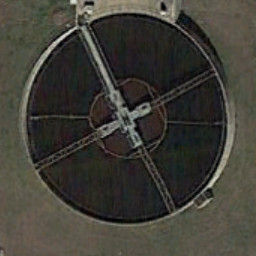

In [5]:
image=dataset['train'][30300]['image']
display(image)

In [6]:
dataset = dataset['train']

In [9]:
dataset_list = list(dataset)

# Split the dataset list into train, test, and validation sets
dataset_list,_ = train_test_split(dataset_list, test_size=0.5, random_state=42)
train_data, test_val_data = train_test_split(dataset_list, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

# Extract images and labels from the dictionaries
train_images, train_labels = zip(*[(item['image'], item['label']) for item in train_data])
test_images, test_labels = zip(*[(item['image'], item['label']) for item in test_data])
val_images, val_labels = zip(*[(item['image'], item['label']) for item in val_data])

In [10]:
# Organize train data
train_data = [{'image': image, 'label': label} for image, label in zip(train_images, train_labels)]
# Organize test data
test_data = [{'image': image, 'label': label} for image, label in zip(test_images, test_labels)]
# Organize validation data
val_data = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [11]:
# print(train_data[10]['label'])

In [12]:
# image=val_data[110]['image']
# display(image)

In [13]:
# len(train_data)

In [14]:
label_list=[]
prev_index=-1
for i in range(0,38):
  label_list.append(i)

In [15]:
to_tensor = transforms.ToTensor()

In [16]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=256),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [17]:
class CustomDataset(Dataset):
  def __init__(self,original_dataset,transform=None):
    self.original_dataset=original_dataset
    self.transform=transform

  def __len__(self):
    return len(self.original_dataset)

  def __getitem__(self,index):
    image = self.original_dataset[index]['image']
    # image_triplet.append(image)
    img1 = self.transform(image)
    img2 = self.transform(image)
    # for i in range(2):
    #   augmented_image = self.transform(image)
    #   image_triplet.append(augmented_image)
    tensor_image = to_tensor(image)
    # image_triplet.append(tensor_image)
    return (img1, img2, tensor_image),self.original_dataset[index]['label']

In [18]:
d_train = CustomDataset(train_data,contrast_transforms)
d_test = CustomDataset(test_data,contrast_transforms)
d_val = CustomDataset(val_data,contrast_transforms)

In [19]:
# images = d_train.__getitem__(1410)
# image1_np = transforms.ToPILImage()(images[0][0]).convert("RGB")
# image2_np = transforms.ToPILImage()(images[0][1]).convert("RGB")
# image3_np = transforms.ToPILImage()(images[0][2]).convert("RGB")
# fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# axes[0].imshow(image1_np)
# axes[0].set_title('Aug Image 1')

# axes[1].imshow(image2_np)
# axes[1].set_title('Aug Image 2')

# axes[2].imshow(image3_np)
# axes[2].set_title('Orig Image')
# for ax in axes:
#     ax.axis('off')

# plt.show()


In [20]:
batch_size = 4
shuffle = True
dataloader_train = DataLoader(d_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(d_test, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=batch_size, shuffle=True)

In [21]:
# for batch in dataloader_train:
#     # 'batch' contains the augmented and target images along with the label of the image
#     inputs, targets = batch
#     print("Target shape:", targets.shape)
#     print(inputs[1].size())
#     image1_np = transforms.ToPILImage()(inputs[0][0]).convert("RGB")
#     display(image1_np)
#     image1_np = transforms.ToPILImage()(inputs[1][0]).convert("RGB")
#     display(image1_np)
#     image1_np = transforms.ToPILImage()(inputs[2][0]).convert("RGB")
#     display(image1_np)
#     print("Targets:", targets)
#     break

In [22]:
# for batch in dataloader_val:
#     # 'batch' contains the augmented and target images along with the label of the image
#     inputs, targets = batch
#     print("Target shape:", targets.shape)
#     print(inputs[1].size())
#     image1_np = transforms.ToPILImage()(inputs[0][0]).convert("RGB")
#     display(image1_np)
#     image1_np = transforms.ToPILImage()(inputs[1][0]).convert("RGB")
#     display(image1_np)
#     image1_np = transforms.ToPILImage()(inputs[2][0]).convert("RGB")
#     display(image1_np)
#     print("Targets:", targets)
#     break

In [23]:
def nt_xent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)
#     print(out_1)
    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)
    # print(sim)
    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)
    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log(pos / neg).mean()
    return loss

In [24]:
from torchvision.models import resnet18
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        channel_attention = self.channel_attention(x)
        spatial_attention = self.spatial_attention(x)
        out = x * channel_attention * spatial_attention
        return out


# Load pre-trained ResNet-18
resnet18_model = resnet18(pretrained=True)


class ResNet18WithCBAM(nn.Module):
    def __init__(self):
        super(ResNet18WithCBAM, self).__init__()
        # Remove the original fully connected layer
        self.resnet18_features = nn.Sequential(*list(resnet18_model.children())[:-1])
        
        # Add CBAM module on the penultimate layer the ouptut is of the form f(x)+x where x is the features(penultimate layer output) from the resnet 18 model
        self.cbam = CBAM(512)

    def forward(self, x):
        # Get the penultimate layer output
        x = self.resnet18_features(x)
        
        # Apply CBAM
        x_cbam = self.cbam(x)
        
        # Add CBAM output to the original penultimate layer output
        x = x + x_cbam

        return x

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s] 


In [25]:
resnet18 = ResNet18WithCBAM()
dummy_input = torch.randn((16,3,256,256))
b = resnet18(dummy_input)
print(b.size())
print(resnet18)

torch.Size([16, 512, 1, 1])
ResNet18WithCBAM(
  (resnet18_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

In [26]:
up_sample_model = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(512,2048, kernel_size=1),nn.BatchNorm2d(2048),nn.ReLU())
projection_model = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))

/tmp/ipykernel_137/993523011.py:2: UnderReviewWarning: The feature Flatten is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  projection_model = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))


In [27]:
model = nn.Sequential(resnet18,up_sample_model,projection_model)

In [28]:
# dummy_input = torch.randn((16, 3, 256, 256))
# print(model(dummy_input))

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [30]:
device_of_model = next(model.parameters()).device
print("Model is on:", device_of_model)

Model is on: cuda:0


In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [32]:
!pip install tqdm
from tqdm import tqdm

In [33]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 4
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/4:   0%|          | 0/10640 [00:00<?, ?it/s]

In [34]:
epochs=4
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[0] = t_in1[0].to(device)
    t_in1[1] = t_in1[1].to(device)
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    # print(t_in1.size())
    # print(t_in2.size())
    output1=model(t_in1[0])
    output2=model(t_in1[1])
#     print(output1)
    model.zero_grad()
    loss=nt_xent_loss(output1,output2,0.5)
#     print(loss)
    net_loss+=loss.item()
    loss.backward()
    optimizer.step()
    pbar.update(1)
  scheduler.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  model.eval()
  eval_acc_temp=0
  eval_acc=0
  eval_steps=0

  for batch in dataloader_val:
      # batch=tuple(t.to(device) for t in batch)
      t_in1,t_labels=batch
      t_in1[0] = t_in1[0].to(device)
      t_in1[1] = t_in1[1].to(device)
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)

      output1=model(t_in1[0])
      output2=model(t_in1[1])
      # print(output1)
      eval_acc_temp=nt_xent_loss(output1,output2,0.5)
      eval_acc+=eval_acc_temp.item()
      eval_steps+=1
      acc=eval_acc/eval_steps
  print("validation loss is "+str(acc))
pbar.close()



training1/4


Epoch 1/4:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [1/4] - Loss: 0.4124
Validation
validation loss is 0.7465962963954856


training2/4


Epoch 2/4:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [2/4] - Loss: 0.2250
Validation
validation loss is 0.6210013000658109


training3/4


Epoch 3/4:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [3/4] - Loss: 0.1645
Validation
validation loss is 0.5479334887207012


training4/4


Epoch 4/4:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [4/4] - Loss: 0.1296
Validation
validation loss is 0.46120916760673136


In [35]:
for param in resnet18.parameters():
    param.requires_grad = False

In [36]:
classification_layer=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))

/tmp/ipykernel_137/2711434965.py:1: UnderReviewWarning: The feature Flatten is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  classification_layer=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))


In [37]:
dummy_input = torch.randn((16,512,1,1))
print(classification_layer(dummy_input).size())

torch.Size([16, 38])


In [38]:
final_model = nn.Sequential(resnet18,classification_layer)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = final_model.to(device)
summary(final_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [40]:
num_classes = 38  # Replace with the actual number of classes
logits = torch.randn(5, num_classes)  # Example logits
target_labels = torch.randint(0, num_classes, (5,))  
print(logits.size())
print(target_labels)

torch.Size([5, 38])
tensor([13,  6,  5, 27, 35])


In [41]:
def ce(out,label):
    return F.cross_entropy(out,label)

In [42]:
pred = torch.randn(16,num_classes)
target_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
target_labels = torch.tensor(target_labels)
print(ce(pred,target_labels))

tensor(4.2389)


In [43]:
correct_pred = 0
predicted_class = [1,2,3,4,5]
predicted_class = torch.tensor(predicted_class)
labels = [1,2,4,5,1]
labels = torch.tensor(labels)
correct_pred += (predicted_class == labels).sum().item()
print(correct_pred)

2


In [44]:
optimizer2 = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)

In [45]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 5
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/5:   0%|          | 0/13300 [00:00<?, ?it/s]

In [46]:
epochs=5
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  final_model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
#     t_in1[0] = t_in1[0].to(device)
#     t_in1[1] = t_in1[1].to(device)
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    output = final_model(t_in1[2])
#     print(output1)
    final_model.zero_grad()
    loss=ce(output,t_labels)
#     print(loss)
    net_loss+=loss.item()
    loss.backward()
    optimizer2.step()
    pbar.update(1)
  scheduler2.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  final_model.eval()
  eval_loss_temp=0
  eval_loss=0
  eval_steps=0
  correct_pred = 0
  total_pred = 0
  accuracy = 0
  for batch in dataloader_val:
      # batch=tuple(t.to(device) for t in batch)
      t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)
      output = final_model(t_in1[2])
      # print(output1)
      eval_loss_temp=ce(output,t_labels)
      eval_loss+=eval_loss_temp.item()
      eval_steps+=1
      acc=eval_loss/eval_steps
      _,predicted_class = torch.max(output,1)
      correct_pred += (predicted_class == t_labels).sum().item()
      total_pred += t_labels.size(0)
  print("Validation loss is "+str(acc))
  accuracy = (correct_pred/total_pred)*100
  print("Validation accuracy is "+str(accuracy)+"%")
pbar.close()



training1/5


Epoch 1/5:   0%|          | 0/2660 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/5] - Loss: 0.7328
Validation
Validation loss is 0.24946136114346268
Validation accuracy is 93.42105263157895%


training2/5


Epoch 2/5:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [2/5] - Loss: 0.5126
Validation
Validation loss is 0.2552637982524942
Validation accuracy is 94.12280701754386%


training3/5


Epoch 3/5:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [3/5] - Loss: 0.4208
Validation
Validation loss is 0.17921316983094635
Validation accuracy is 95.17543859649122%


training4/5


Epoch 4/5:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [4/5] - Loss: 0.3956
Validation
Validation loss is 0.17616034659627997
Validation accuracy is 95.5701754385965%


training5/5


Epoch 5/5:   0%|          | 0/2660 [00:00<?, ?it/s]

Epoch [5/5] - Loss: 0.3544
Validation
Validation loss is 0.2791797534380829
Validation accuracy is 94.21052631578948%


In [47]:
for batch in dataloader_train:
    img,label = batch
    img[2] = img[2].to(device)
    label = label.to(device)
    out1 = final_model(img[2])
    _,predicted_class = torch.max(out1,1)
    print(predicted_class)
    print(label)
    break

tensor([27, 28, 10, 21], device='cuda:0')
tensor([27, 28, 10, 21], device='cuda:0')


In [48]:
print("Test")
final_model.eval()
test_loss_temp=0
test_loss=0
test_steps=0
correct_pred = 0
total_pred = 0
accuracy = 0
for batch in dataloader_test:
  # batch=tuple(t.to(device) for t in batch)
  t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
  t_in1[2] = t_in1[2].to(device)
  t_labels = t_labels.to(device)
  output = final_model(t_in1[2])
  # print(output1)
  test_loss_temp=ce(output,t_labels)
  test_loss+=test_loss_temp.item()
  test_steps+=1
  acc=test_loss/test_steps
  _,predicted_class = torch.max(output,1)
  correct_pred += (predicted_class == t_labels).sum().item()
  total_pred += t_labels.size(0)
print("Test loss is "+str(acc))
accuracy = (correct_pred/total_pred)*100
print("Test accuracy is "+str(accuracy)+"%")

Test
Test loss is 0.38632894063372514
Test accuracy is 94.07894736842105%
